In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import math
import networkx as nx

### Import Environment

In [2]:
Atascosa = nx.read_shp(r'Atascosa\edges.shp')
nodes_data = nx.read_shp(r'Atascosa\nodes.shp')

for e in Atascosa.edges.data():
    if (e[1], e[0]) not in Atascosa:
        Atascosa.add_edge(e[1], e[0])
        
        for A in e[2]:
            Atascosa[e[1]][e[0]][A] = e[2][A]
        
for n in nodes_data.nodes.data():
    for A in n[1]:
        Atascosa.nodes[n[0]][A] = n[1][A]

In [3]:
clusters = []
for x in Atascosa.nodes.data():
    if x[1]['well']=='1':
        clusters.append(tuple([x[0], x[1]['Size']])) # the size variable can be removed if unwanted
        
clusters

[((-98.346983635, 28.90336087), 2),
 ((-98.68425455333333, 29.17836441), 3),
 ((-98.74054584333332, 28.83449039333333), 3),
 ((-98.63923124499999, 28.85497386), 2),
 ((-98.80039774, 29.184725325000002), 2),
 ((-98.70341999, 29.17525964), 1),
 ((-98.76985064, 28.9485843), 1),
 ((-98.72930564, 29.05115702), 1),
 ((-98.16279453499999, 28.750711709999997), 2),
 ((-98.735289493, 28.884813801), 20),
 ((-98.75172126999999, 28.87813230142857), 7),
 ((-98.52448421, 28.87908197), 1),
 ((-98.19564892, 28.7736562), 1),
 ((-98.73690283, 28.81946942), 1),
 ((-98.28129662, 28.89002402), 1),
 ((-98.76065773, 29.19713571), 1),
 ((-98.73506198285712, 28.90698824714286), 7),
 ((-98.72745071, 28.86660764), 1),
 ((-98.65527190210526, 29.18506977894737), 19),
 ((-98.72010547, 29.18036479), 1),
 ((-98.34134356999999, 28.920911033333336), 6),
 ((-98.791694495, 29.00298879), 2)]

### Reinforcement Learner

For our learner algorithm, I've decided to use a Deep Q Learning (DQL) network, in order to help generalize each state. The main idea came from this link: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
<br>MLP Code: https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [4]:
# Hyperparameter Control Panel

R_EARTH = 3958.8                # Radius of Earth in miles

OUTPUT_SIZE = 1                 # Length of NN output
NUM_FEATURES = 6                # Length of NN input (# of features)

EPSILON_START = 5               # Initial epsilon value for dynamic epsilon greedy
EPSILON_CONST = 0.25            # Constant epsilon value for static epsilon greedy
EPSILON_STATIC = False          # Boolean value that determines type of epsilon value

lr = 0.1                        # Learning rate of NN

BATCH_SIZE = 7                  # Batch size when training learner [MAX VALUE: ~8]
FULL_SIZE = len(clusters)       # Full size of cluster dataset

START_NODE = 0                  # Index of starting cluster
num_episodes = 300

In [5]:
import random
import torch
import torch.nn as nn

class DQN(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(DQN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.LeakyReLU(0.2)
            self.fc2 = torch.nn.Linear(self.hidden_size, OUTPUT_SIZE)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.iter = 0
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

It'll be helpful to define a function to find the distance between clusters, as well as the dot product between a path and its center:

In [6]:
def total_distance(i, j): # Takes in indices of clusters and returns the total distance
    distance = 0
    path = nx.shortest_path(Atascosa, clusters[i][0], clusters[j][0])

    for k in range(1, len(path)): # Identifies the edge, stores the distance and adds it to the total distance
        distance += Atascosa.edges[path[k-1], path[k]]['Distance']
    return distance

In order to speed the process up, we can create a table storing the distances between the different clusters.

In [7]:
DISTANCE_TABLE = np.array([[total_distance(i, j) for i in range(FULL_SIZE)] for j in range(FULL_SIZE)])
DISTANCE_TABLE

array([[ 0.        , 44.95062347, 43.81495241, 33.21580998, 57.79313555,
        49.05798597, 45.57642782, 54.6229777 , 33.83849651, 40.35973349,
        41.32681423, 22.39260474, 35.28224566, 44.00517113, 11.72298965,
        54.2015325 , 43.90948399, 39.2480897 , 43.4999049 , 50.5032441 ,
         3.11242842, 52.33968989],
       [44.85959584,  0.        , 35.37004275, 36.618409  , 13.11175291,
         4.38043155, 25.25598503, 19.70576749, 79.40017943, 27.75500171,
        28.72208244, 43.62581941, 80.84392858, 35.56026148, 50.17208016,
         9.52014986, 25.85955075, 31.69847035,  2.86905495,  5.82186145,
        43.01208151, 30.22014208],
       [41.19067587, 35.41511033,  0.        , 11.97112655, 48.25379419,
        39.52247284, 15.06172478, 24.15486959, 54.06193618,  8.08061882,
         9.04769956, 18.97834442, 55.50568533,  1.5542895 , 40.65239957,
        44.66219114, 15.66172109,  6.44595646, 33.96439176, 40.96390274,
        41.90916024, 21.88810383],
       [33.21580998

In [8]:
def norm_dot_product(x, y, z=None, CORE=None): # x, y are start / end coordinates of a path (respectively)
    # z is called whenever an angle is formed between two edges; CORE is called whenever comparing the angle to the current average cluster point
    
    norm = lambda x, y: np.sqrt((y[0]-x[0])**2 + (y[1]-x[1])**2)
    
    if z==None:
        return ( (y[0]-x[0])*(CORE[0]-x[0]) + (y[1]-x[1])*(CORE[1]-x[1]) ) / ( norm(x, CORE)*norm(x, y) )
    return ( (y[0]-x[0])*(z[0]-y[0]) + (y[1]-x[1])*(z[1]-y[1]) ) / ( norm(x, y)*norm(y, z) )

Below is a batch-generator: generates a random batch of indices within the specified range:

In [9]:
def get_batch():
    temp = [i for i in range(FULL_SIZE)]
    temp.remove(START_NODE) # we don't include the start node
    x = []
    
    for _ in range(BATCH_SIZE):
        x.append(temp.pop(random.randint(0, len(temp)-1)))
    return x

The iterator function returns the optimal path for a given batch (WARNING: Any batch size greater than ~8 will take a LONG time)

In [10]:
memo = [] # Memoization to prune bad branches and speed up process
def iterator(state, reset=True): # reset variable refers to when iterator is called: clears memory
    if reset:
        memo.clear()
        
    if state[2]==[]: # End state
        return [state[3], state[1]]
    
    for s in memo: # Runs through memory
        if s[0]==state[0] and set(s[1])==set(state[1]): # if they have same current position and similar past experiences...
            if state[3] >= s[3]: # stop if greater travel distance
                return [1e99, []]
            memo.remove(s) # replace memory value if better
            break
            
    memo.append(state) # add state to memory
    
    # Store all potential newStates in a list
    newStates = [(state[2][i], state[1]+[state[2][i]], state[2][:i]+state[2][i+1:], state[3]+DISTANCE_TABLE[state[0], state[2][i]]) for i in range(len(state[2]))]
    
    # Returns the path with the shortest total distance out of all potential paths
    return min( iterator(newStates[i] , False) for i in range(len(state[2])) )

State's will be comprised of: (0: Position [index], 1: Past actions, 2: Available actions, 3: Distance already traveled)

In [11]:
def extract_features(state, action): #action: node we're considering traveling to (index)
    # Measure existing "node-core" (average point of remaining clusters)
    clusters_remaining_x = [clusters[i][0][0] for i in state[2]+[action]]
    clusters_remaining_y = [clusters[i][0][1] for i in state[2]+[action]]
    CORE = sum(clusters_remaining_x)/(len(state[2])+1), sum(clusters_remaining_y)/(len(state[2])+1)
    
    distance = DISTANCE_TABLE[state[0], action] / R_EARTH
    
    angle_from_prev = 0
    if len(state[1])>1:
        angle_from_prev = norm_dot_product(clusters[state[1][-2]][0], clusters[state[0]][0], clusters[action][0])
        
    angle_to_core = norm_dot_product(clusters[state[0]][0], clusters[action][0], CORE=CORE)
    norm = lambda x, y: np.sqrt((y[0]-x[0])**2 + (y[1]-x[1])**2)
    distance_to_core = norm(clusters[state[0]][0], CORE)
    
    percent_visited = len(state[1]) / (len(state[1])+len(state[2]))
    
    choices = [(DISTANCE_TABLE[state[0], a], a) for a in state[2]+[action]]
    choices.sort()
    percent_closest = [i+1 for i in range(len(state[2])+1) if choices[i][1]==action][0] / (len(state[2])+1)
    
    x = [ distance, angle_from_prev, angle_to_core, distance_to_core, percent_visited, percent_closest ]
    
    return torch.FloatTensor(x)

In [12]:
policy_net = DQN(NUM_FEATURES, 2*NUM_FEATURES)

def select_action(state, opt=False): # epsilon greedy - opt: no exploration
    policy_net.iter += 1
    
    if EPSILON_STATIC: # If using a constant epsilon value, run the following
        if random.random() > EPSILON_CONST or opt:
            output = torch.FloatTensor([policy_net.forward(extract_features(state, action)) for action in state[2]])
            return state[2].pop( torch.argmax(output) )
        else:
            return state[2].pop(random.randint(0, len(state[2])-1))
    
    # Other use the dynamic epsilon value
    if random.random() > EPSILON_START/math.sqrt(policy_net.iter) or opt:
        output = torch.FloatTensor([policy_net.forward(extract_features(state, action)) for action in state[2]])
        return state[2].pop( torch.argmax(output) )
    else:
        return state[2].pop(random.randint(0, len(state[2])-1))

In [13]:
def incorporate_feedback(state, action, reward, newState):
    x = extract_features(state, action)
    Q = policy_net.forward(x)
    
    criterion = nn.MSELoss()
    
    loss = criterion(Q, reward*torch.ones(OUTPUT_SIZE)) # Loss = (Q-I[x])^2
        
    optimizer = torch.optim.SGD(policy_net.parameters(), lr = lr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return

Below is the training method for the learner:

In [14]:
SCORES = []

for i in range(num_episodes):
    print("Episode #", i)
    SCORES.append(0)
    
    # First restart the 'game'
    actions = get_batch() # Actions are the indices of clusters <- remove once visited
    state = (START_NODE, [START_NODE], actions, 0)
    PI_opt = iterator(state)[1] # The optimal policy for the batch
    print('Optimal Path:', PI_opt)
    
    while state!=None:
        action = select_action(state)
        optimal_action = PI_opt[len(state[1])]
        
        D = DISTANCE_TABLE[state[0], action]
        
        newState = (action, state[1]+[action], state[2], state[3]+D)
        
        if action!=PI_opt[len(state[1])]: #update the optimal policy if a different action was taken
            PI_opt = iterator(newState)[1]
        
        reward = 2*int(action==optimal_action)-1 # reward is 1 if learner replicates PI_opt, -1 otherwise
        
        if len(newState[2])==0: # If no new possible actions, set newState to None
            print('Learner Path:', newState[1])
            newState = None
        
        incorporate_feedback(state, action, reward, newState)
        SCORES[-1] += reward
        
        state = newState

Episode # 0
Optimal Path: [0, 20, 11, 10, 6, 7, 1, 19, 4]
Learner Path: [0, 19, 6, 11, 10, 1, 20, 7, 4]
Episode # 1
Optimal Path: [0, 14, 8, 11, 3, 17, 6, 18, 19]
Learner Path: [0, 3, 11, 14, 19, 18, 6, 8, 17]
Episode # 2
Optimal Path: [0, 20, 12, 3, 17, 2, 6, 18, 4]
Learner Path: [0, 20, 12, 6, 2, 4, 18, 17, 3]
Episode # 3
Optimal Path: [0, 11, 3, 17, 2, 16, 21, 18, 5]
Learner Path: [0, 21, 3, 17, 5, 11, 2, 16, 18]
Episode # 4
Optimal Path: [0, 20, 8, 12, 11, 13, 2, 16, 1]
Learner Path: [0, 1, 8, 16, 2, 13, 11, 20, 12]
Episode # 5
Optimal Path: [0, 8, 11, 3, 13, 2, 6, 1, 5]
Learner Path: [0, 8, 3, 2, 13, 6, 5, 11, 1]
Episode # 6
Optimal Path: [0, 20, 18, 5, 19, 7, 9, 10, 2]
Learner Path: [0, 20, 10, 7, 19, 18, 5, 9, 2]
Episode # 7
Optimal Path: [0, 8, 13, 6, 7, 19, 5, 15, 4]
Learner Path: [0, 5, 15, 13, 4, 7, 6, 8, 19]
Episode # 8
Optimal Path: [0, 20, 8, 12, 13, 17, 16, 5, 4]
Learner Path: [0, 20, 8, 5, 4, 13, 16, 17, 12]
Episode # 9
Optimal Path: [0, 8, 2, 17, 10, 16, 6, 7, 18]
Lear

Optimal Path: [0, 8, 12, 11, 3, 2, 16, 6, 1]
Learner Path: [0, 8, 12, 11, 3, 2, 6, 16, 1]
Episode # 79
Optimal Path: [0, 12, 11, 3, 2, 9, 10, 18, 19]
Learner Path: [0, 12, 11, 2, 9, 10, 3, 18, 19]
Episode # 80
Optimal Path: [0, 20, 3, 13, 2, 21, 7, 19, 5]
Learner Path: [0, 13, 3, 2, 21, 19, 5, 20, 7]
Episode # 81
Optimal Path: [0, 14, 8, 12, 3, 7, 18, 19, 4]
Learner Path: [0, 14, 8, 12, 3, 7, 4, 19, 18]
Episode # 82
Optimal Path: [0, 8, 13, 17, 10, 21, 7, 18, 4]
Learner Path: [0, 8, 18, 4, 7, 10, 17, 13, 21]
Episode # 83
Optimal Path: [0, 20, 8, 3, 9, 1, 19, 15, 4]
Learner Path: [0, 8, 20, 3, 9, 1, 19, 15, 4]
Episode # 84
Optimal Path: [0, 14, 8, 3, 17, 9, 7, 19, 1]
Learner Path: [0, 14, 8, 3, 17, 9, 7, 19, 1]
Episode # 85
Optimal Path: [0, 3, 9, 16, 6, 21, 5, 19, 15]
Learner Path: [0, 3, 9, 6, 16, 21, 5, 19, 15]
Episode # 86
Optimal Path: [0, 14, 12, 13, 2, 16, 6, 21, 7]
Learner Path: [0, 14, 2, 13, 6, 16, 21, 7, 12]
Episode # 87
Optimal Path: [0, 20, 8, 12, 13, 17, 10, 21, 19]
Learne

Optimal Path: [0, 14, 12, 11, 2, 9, 16, 7, 1]
Learner Path: [0, 14, 12, 11, 9, 2, 16, 7, 1]
Episode # 156
Optimal Path: [0, 3, 17, 2, 10, 9, 16, 6, 15]
Learner Path: [0, 3, 17, 9, 10, 6, 16, 2, 15]
Episode # 157
Optimal Path: [0, 8, 11, 17, 2, 10, 6, 21, 15]
Learner Path: [0, 21, 10, 6, 17, 2, 11, 8, 15]
Episode # 158
Optimal Path: [0, 20, 12, 11, 3, 16, 6, 21, 7]
Learner Path: [0, 20, 12, 16, 11, 3, 6, 21, 7]
Episode # 159
Optimal Path: [0, 3, 13, 2, 9, 21, 7, 18, 1]
Learner Path: [0, 3, 9, 2, 1, 18, 7, 21, 13]
Episode # 160
Optimal Path: [0, 8, 11, 3, 17, 9, 10, 7, 4]
Learner Path: [0, 8, 11, 3, 17, 9, 10, 7, 4]
Episode # 161
Optimal Path: [0, 20, 11, 2, 9, 6, 7, 15, 4]
Learner Path: [0, 15, 20, 6, 9, 2, 11, 7, 4]
Episode # 162
Optimal Path: [0, 20, 14, 2, 10, 9, 16, 21, 1]
Learner Path: [0, 20, 14, 9, 10, 2, 16, 21, 1]
Episode # 163
Optimal Path: [0, 14, 12, 13, 2, 6, 18, 19, 15]
Learner Path: [0, 14, 6, 2, 13, 18, 19, 15, 12]
Episode # 164
Optimal Path: [0, 20, 12, 11, 9, 10, 6, 21

Optimal Path: [0, 8, 12, 11, 2, 9, 6, 19, 15]
Learner Path: [0, 8, 12, 11, 9, 2, 6, 19, 15]
Episode # 233
Optimal Path: [0, 11, 3, 13, 2, 9, 21, 5, 4]
Learner Path: [0, 11, 3, 13, 2, 9, 21, 5, 4]
Episode # 234
Optimal Path: [0, 14, 12, 11, 3, 13, 10, 18, 5]
Learner Path: [0, 18, 5, 11, 3, 10, 12, 14, 13]
Episode # 235
Optimal Path: [0, 12, 13, 17, 16, 6, 19, 15, 4]
Learner Path: [0, 12, 13, 17, 6, 16, 19, 15, 4]
Episode # 236
Optimal Path: [0, 11, 3, 10, 16, 7, 18, 5, 4]
Learner Path: [0, 11, 3, 10, 16, 7, 18, 5, 4]
Episode # 237
Optimal Path: [0, 3, 17, 13, 2, 10, 7, 19, 5]
Learner Path: [0, 3, 17, 5, 19, 7, 10, 2, 13]
Episode # 238
Optimal Path: [0, 20, 8, 12, 11, 13, 18, 1, 19]
Learner Path: [0, 20, 8, 12, 11, 13, 18, 1, 19]
Episode # 239
Optimal Path: [0, 20, 14, 2, 13, 9, 10, 21, 19]
Learner Path: [0, 20, 14, 9, 10, 21, 2, 13, 19]
Episode # 240
Optimal Path: [0, 8, 12, 2, 17, 7, 19, 1, 5]
Learner Path: [0, 8, 12, 2, 17, 7, 19, 5, 1]
Episode # 241
Optimal Path: [0, 14, 11, 3, 9, 16

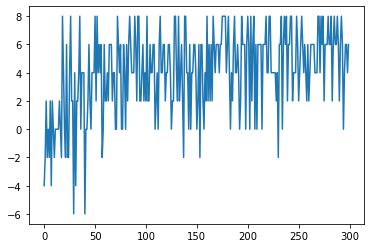

In [15]:
plt.plot(SCORES) # The higher the value, the more success

Now it's time to evaluate the learning method on the full data set:

In [16]:
actions = [i for i in range(FULL_SIZE)] # Now we're working with the full set of clusters
actions.remove(START_NODE)
state = (START_NODE, [START_NODE], actions, 0)

traveled_distance = 0
actions = [START_NODE] # We will now re-utilize actions as a memory of the actions taken in order
while state!=None:
    action = select_action(state, opt=True)
    actions.append(action)
        
    D = DISTANCE_TABLE[state[0], action]
    traveled_distance += D
    print(D) # This print statement allows us to monitor the movements and see notice any unnecessarily long paths
    state = (action, state[1]+[action], state[2], state[3]+D)
    if len(state[2])==0:
        state = None
        
actions

11.722989652187369
30.458242823252547
4.616447050897909
34.12592443234329
11.003478535030151
10.028540381264893
6.445956457673559
1.5542895038108977
8.270837549507926
1.432658515533858
8.41376447733564
5.597827711296021
12.361089780318466
19.00496891119527
16.771819897298894
5.116148207372432
4.7520946096437005
10.265543644428579
5.218602507375569
2.869054947507027
42.40408406428894


[0, 14, 8, 12, 11, 3, 17, 2, 13, 9, 10, 6, 16, 21, 7, 19, 15, 4, 5, 1, 18, 20]

Listed below is the travel distance during evaluation. Note that a random path may average around 600 miles, and go as high as 1000 miles.

In [17]:
traveled_distance

252.43436365956296

Finally, let's store this pathing process as a gif.

In [18]:
# Here we compile the roads taken by action # and x, y coordinates
directions_x = [[] for _ in range(len(actions)-1)]
directions_y = [[] for _ in range(len(actions)-1)]

for i in range(1, len(actions)):
    p1, p2 = clusters[actions[i-1]][0], clusters[actions[i]][0]
    temp = nx.shortest_path(Atascosa, p1, p2, weight='Distance')
    for x in temp:
        directions_x[i-1].append(x[0])
        directions_y[i-1].append(x[1])

MovieWriter ffmpeg unavailable; using Pillow instead.


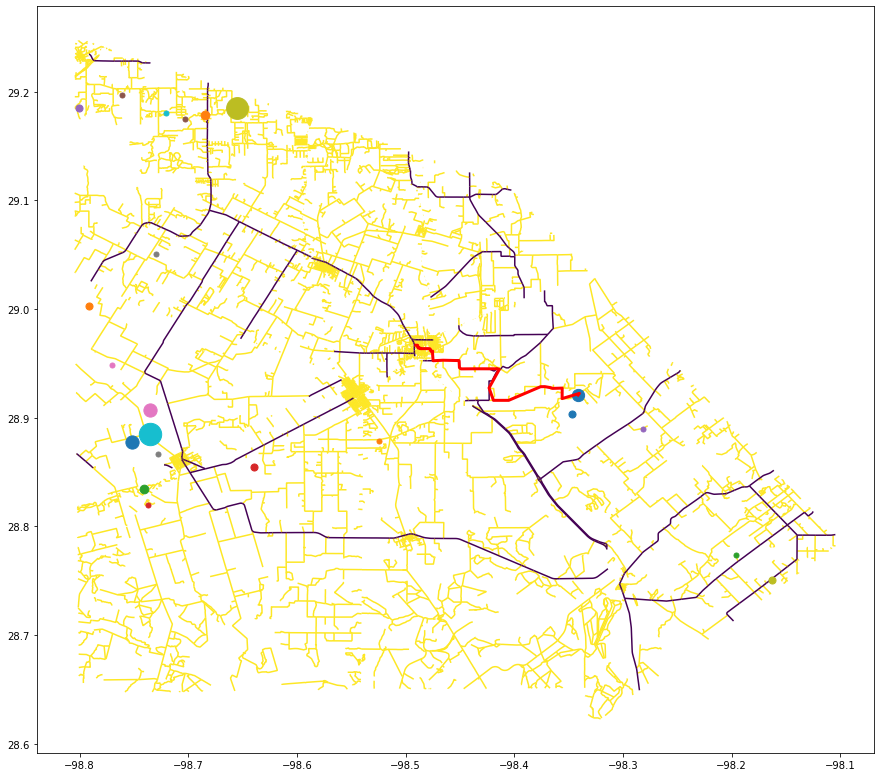

In [19]:
import matplotlib.animation as animation

basemap = gpd.read_file(r'Maps\Basemap013\road013l.shp')

fig, ax = plt.subplots(figsize=(15,15))
xs = []
ys = []
line, = ax.plot(xs, ys, color='r', linewidth=3)

basemap.plot(column='DISP_CODE', ax=ax, figsize=(15,15), zorder=0)

for C in clusters:
    plt.scatter(C[0][0], C[0][1], s=25*C[1])

FULL_DIRECTIONS_X, FULL_DIRECTIONS_Y = [x for X in directions_x for x in X ], [y for Y in directions_y for y in Y ]

# This function is called periodically from FuncAnimation
def animate(i, xs=xs, ys=ys):
    # Add x and y to lists
    xs.append(FULL_DIRECTIONS_X[i])
    ys.append(FULL_DIRECTIONS_Y[i])

    # Limit x and y lists
    line_length = 50
    xs = xs[-line_length:]
    ys = ys[-line_length:]

    line.set_data(np.array(xs), np.array(ys))
    
    return line,

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, frames=len(FULL_DIRECTIONS_X))
ani.save(r'Gifs\Atascosa_batch_pathing_animation.gif', fps=2500)
plt.show()

### Storing the Learner:

The following code below will store the Learning Algorithm as a pth file:

In [20]:
print(policy_net)
torch.save(policy_net, 'Models\Atascosa_Batch.pth')

DQN(
  (fc1): Linear(in_features=6, out_features=12, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In order to load the Learner, run the following cells:

In [21]:
# Model class must be defined somewhere - commented out as class is already included in notebook
'''class DQN(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(DQN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.LeakyReLU(0.2)
            self.fc2 = torch.nn.Linear(self.hidden_size, OUTPUT_SIZE)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.iter = 0
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output'''

'class DQN(nn.Module):\n        def __init__(self, input_size, hidden_size):\n            super(DQN, self).__init__()\n            self.input_size = input_size\n            self.hidden_size  = hidden_size\n            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)\n            self.relu = torch.nn.LeakyReLU(0.2)\n            self.fc2 = torch.nn.Linear(self.hidden_size, OUTPUT_SIZE)\n            self.sigmoid = torch.nn.Sigmoid()\n            \n            self.iter = 0\n            \n        def forward(self, x):\n            hidden = self.fc1(x)\n            relu = self.relu(hidden)\n            output = self.fc2(relu)\n            output = self.sigmoid(output)\n            return output'

This class, as well as other learner methods will eventually be accessible from a python file later on.

In [22]:
model = torch.load('Models\Atascosa_Batch.pth')
model.eval()

DQN(
  (fc1): Linear(in_features=6, out_features=12, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Evaluation

The following code is used to find the optimal path by eye and determine its distance:

In [23]:
for i, C in enumerate(clusters):
    print(i, C)

0 ((-98.346983635, 28.90336087), 2)
1 ((-98.68425455333333, 29.17836441), 3)
2 ((-98.74054584333332, 28.83449039333333), 3)
3 ((-98.63923124499999, 28.85497386), 2)
4 ((-98.80039774, 29.184725325000002), 2)
5 ((-98.70341999, 29.17525964), 1)
6 ((-98.76985064, 28.9485843), 1)
7 ((-98.72930564, 29.05115702), 1)
8 ((-98.16279453499999, 28.750711709999997), 2)
9 ((-98.735289493, 28.884813801), 20)
10 ((-98.75172126999999, 28.87813230142857), 7)
11 ((-98.52448421, 28.87908197), 1)
12 ((-98.19564892, 28.7736562), 1)
13 ((-98.73690283, 28.81946942), 1)
14 ((-98.28129662, 28.89002402), 1)
15 ((-98.76065773, 29.19713571), 1)
16 ((-98.73506198285712, 28.90698824714286), 7)
17 ((-98.72745071, 28.86660764), 1)
18 ((-98.65527190210526, 29.18506977894737), 19)
19 ((-98.72010547, 29.18036479), 1)
20 ((-98.34134356999999, 28.920911033333336), 6)
21 ((-98.791694495, 29.00298879), 2)


Text(101.625, 0.5, 'latitude')

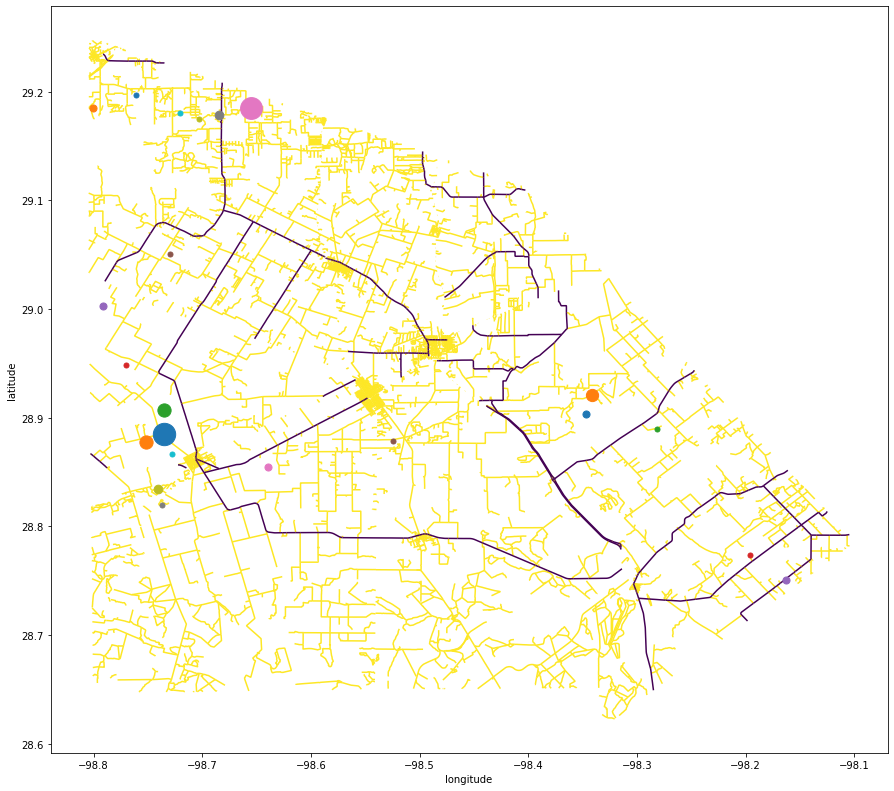

In [24]:
# Plot the clusters - the bigger the size, the greater the cluster
ax = basemap.plot(column='DISP_CODE', figsize=(15,15), zorder=0)
           #[0, 14, 12, 8, 20, 11, 3, 17, 2, 13, 9, 10, 6, 16, 21, 7, 19, 15, 4, 5, 1, 18]
OPT_ORDER = [0, 20, 14, 12, 8, 11, 3, 13, 2, 17, 9, 10, 16, 6, 21, 7, 18, 1, 5, 19, 15, 4]
for i in OPT_ORDER:
    plt.scatter(clusters[i][0][0], clusters[i][0][1], s=25*clusters[i][1])

plt.xlabel('longitude')
plt.ylabel('latitude')

In [25]:
BEST_DISTANCE = 0
for i in range(1, len(clusters)):
    BEST_DISTANCE += DISTANCE_TABLE[OPT_ORDER[i-1], OPT_ORDER[i]]
    
BEST_DISTANCE

208.3493753553273

With that, we conclude the algorithm can obtain as low a distance as 200 miles.